In [15]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from math import sqrt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.recurrent import RNN
import matplotlib.pyplot as plt

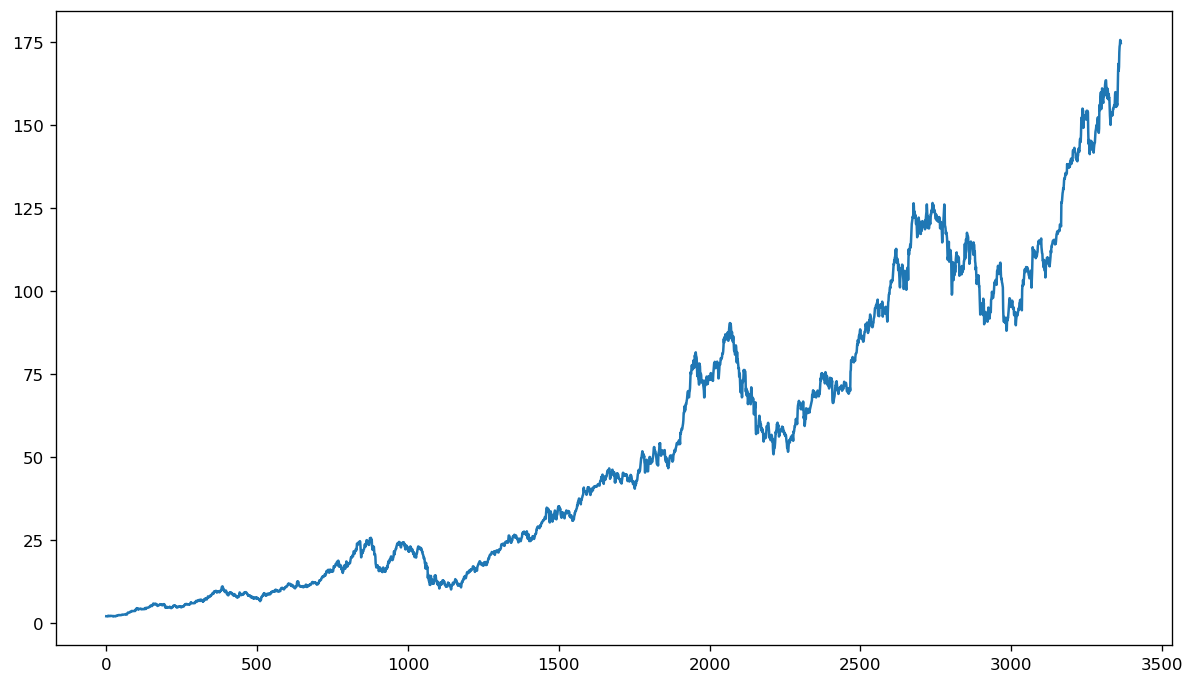

In [16]:
plt.rcParams.update({'figure.figsize':(12,7), 'figure.dpi':120})

df = pd.read_csv('../data_preprocess_v3/aapl.us.csv', header=0, index_col=0)
df.index = [i for i in range(len(df.index))]
df = df[df.index >= 5000]
df.index = [i for i in range(len(df.index))]
plt.plot(df.index, df['Close'])
plt.show()

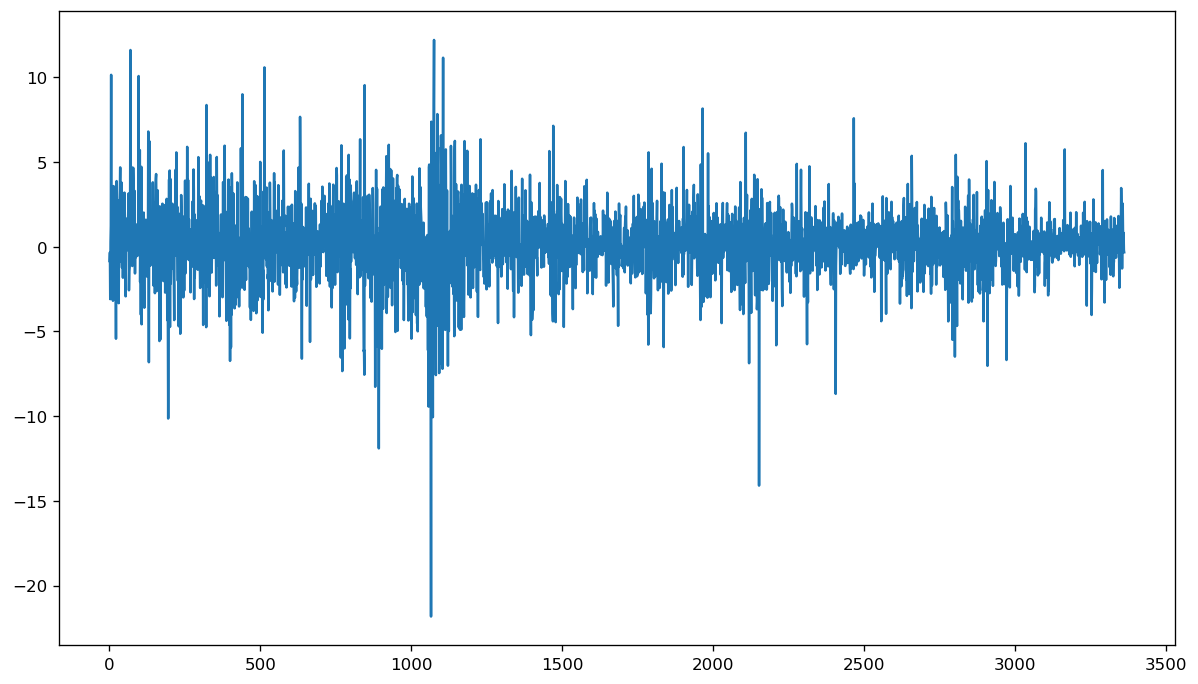

In [17]:
df2 = df['Close'].diff().dropna()
close_diff = df['Close'].diff().dropna()
close_diff_p = (close_diff / df['Close']) * 100
close_diff_p = close_diff_p[1:]

close_diff_p = pd.DataFrame(close_diff_p)
close_diff_p['Volume'] = df['Volume']
plt.plot(close_diff_p.index, close_diff_p['Close'])
plt.show()

In [18]:
def generate_data(df, col, lag):
    new_df = df.loc[:]
    for i in range(1,lag+1):
        col_name = col + '-' + str(i)
        new_df[col_name] = df[col].shift(-i)
        
    return new_df

In [82]:
from sklearn import metrics 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
import seaborn as sns

def show_roc(label, prob):
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    # calculate roc curve for model
    fpr, tpr, _ = roc_curve(label, prob)
    # plot model roc curve
    plt.plot(fpr, tpr, marker='.', label='Logistic')
    # calculate roc auc
    roc_auc = roc_auc_score(label, prob)
    plt.title('ROC AUC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print('ROC AUC : %.3f' % roc_auc)


def show_pr(label, prob):
    # plot no skill precision-recall curve
    no_skill = len(label[label==1]) / len(label)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # calculate precision-recall curve for model
    precision, recall, _ = precision_recall_curve(label, prob, pos_label=1)
    # plot model precision-recall curve
    plt.plot(recall, precision, marker='.', label='Logistic')
    plt.title('PR AUC Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    # calculate roc auc
    auc_score = auc(recall, precision)
    print('PR AUC : %.3f' % auc_score)
    
def show_cm(label, prob, threshold, names): # Confusion Matrix
    cnf_matrix = metrics.confusion_matrix(label, prob > threshold)
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names)
    plt.yticks(tick_marks, names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.xlabel('Actual label')
    plt.ylabel('Predicted label')
    plt.show()
    
def show_f1(label, prob, threshold):
    score = f1_score(label, prob > threshold)
    print('F1 Score : %.3f' % score)
    
def build(label, prob, threshold):
    show_roc(label, prob)
    show_pr(label, prob)
    show_cm(label, prob, threshold, [0, 1])
    show_f1(label, prob, threshold)

In [47]:
new_df = generate_data(close_diff_p, 'Close', 5)

test = 0.2
X_train = new_df[:(int)(len(new_df)*(1-test))].drop(['Volume','Close'], axis=1)
X_test = new_df[(int)(len(new_df)*(1-test)):].drop(['Volume','Close'], axis=1)
y_train = new_df[:(int)(len(new_df)*(1-test))]['Close']
y_test = new_df[(int)(len(new_df)*(1-test)):]['Close']

X_test.index = [i for i in range(1, len(X_test)+1)]
y_test.index = [i for i in range(1, len(y_test)+1)]

X_test.head()

,Close-1,Close-2,Close-3,Close-4,Close-5
1,1.648306,1.113932,-0.759264,-1.253447,1.009182
2,1.113932,-0.759264,-1.253447,1.009182,-0.406977
3,-0.759264,-1.253447,1.009182,-0.406977,-2.669054
4,-1.253447,1.009182,-0.406977,-2.669054,0.677564
5,1.009182,-0.406977,-2.669054,0.677564,-0.793922


In [121]:
inputs = keras.Input(shape=(5, 1))
hidden1 = layers.LSTM(10)(inputs)
hidden2 = layers.Dense(10, activation='relu')(hidden1)
hidden3 = layers.Dense(10, activation='relu')(hidden2)
hidden4 = layers.Dense(10, activation='relu')(hidden3)
outputs = layers.Dense(1)(hidden4)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()

# fit model
model.fit(X_train, y_train, epochs=30, shuffle=False)

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_24 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_25 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_26 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 11        
Total params: 821
Trainable params: 821
Non-trainable params: 0
_________________________________________________________

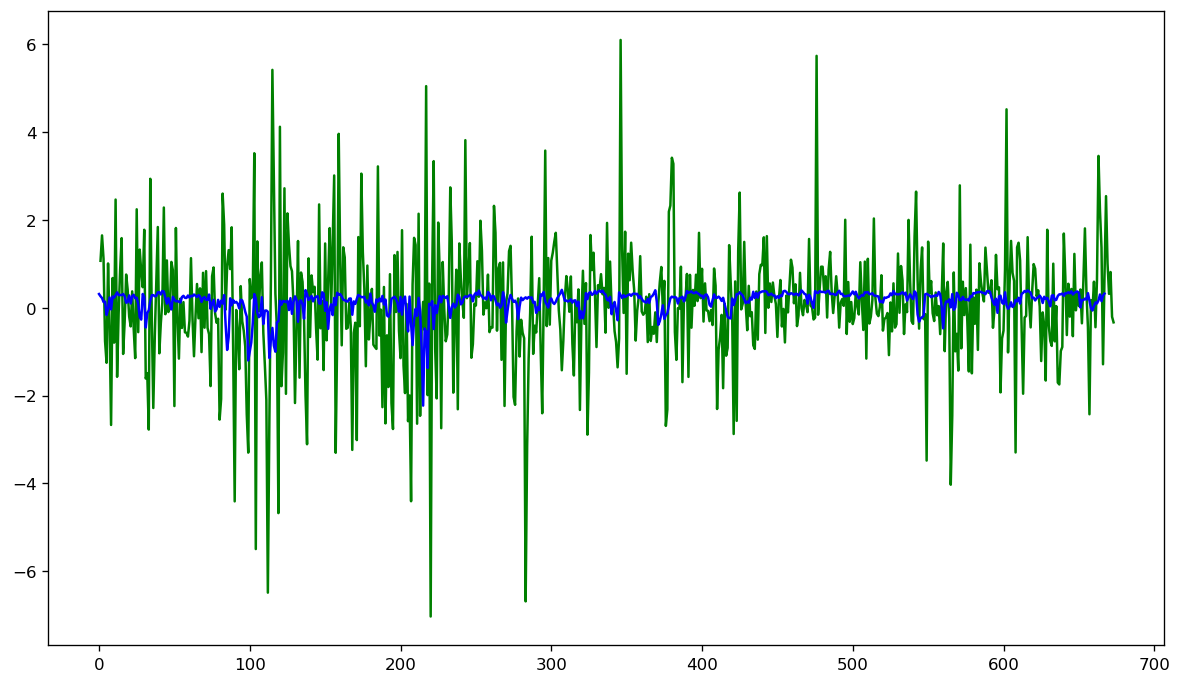

In [122]:
pred = model.predict(X_test)

plt.plot(y_test, 'green', label='Label')
plt.plot(pred, 'blue', label='Prediction')
plt.show()

The classification accuracy for test set: 0.5066864784546805


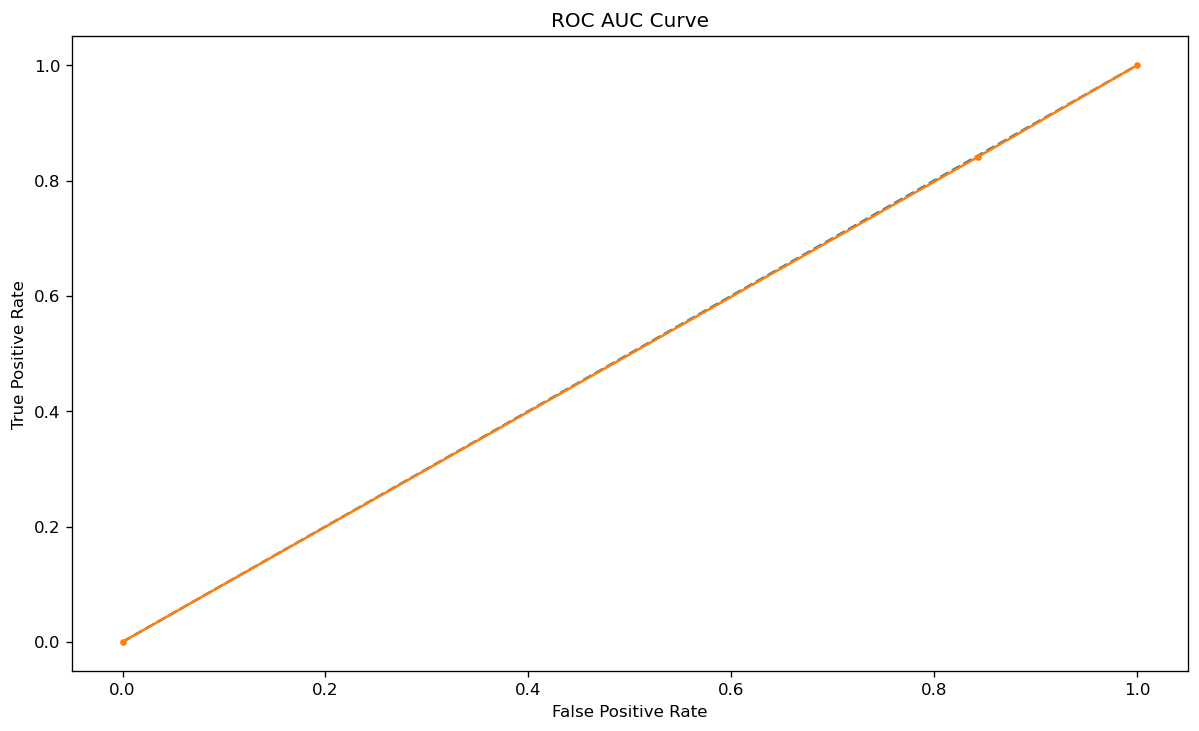

ROC AUC : 0.499


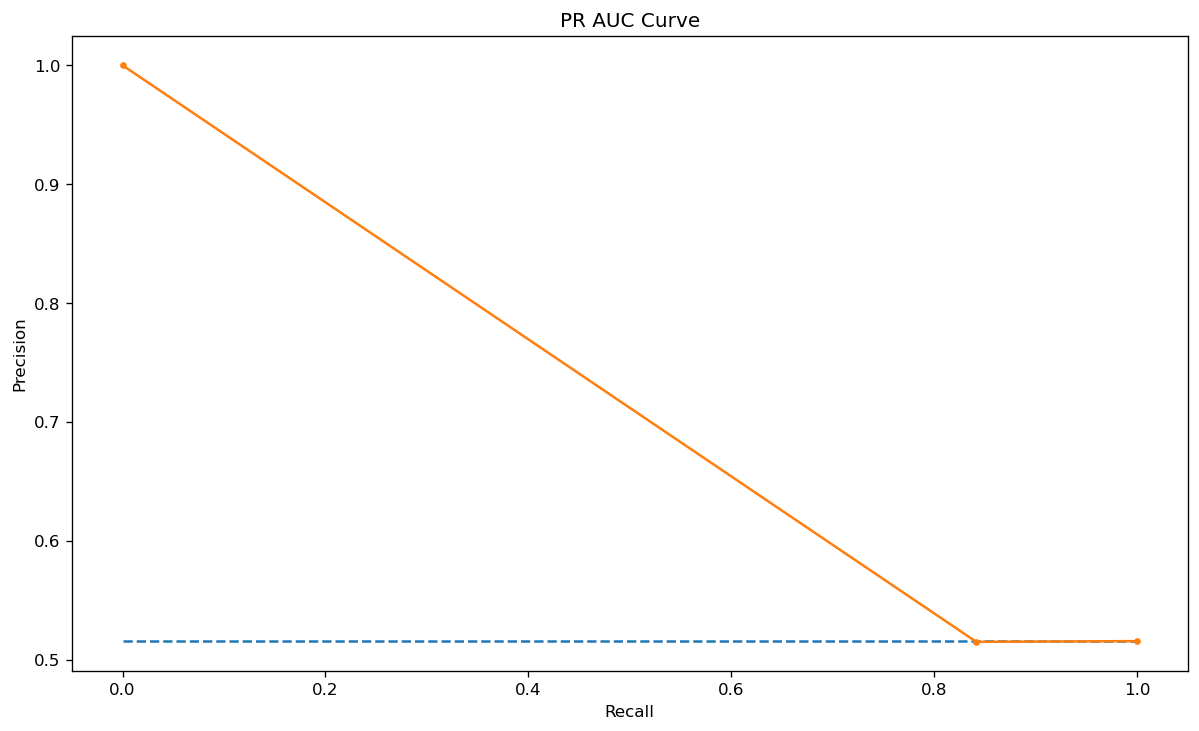

PR AUC : 0.719


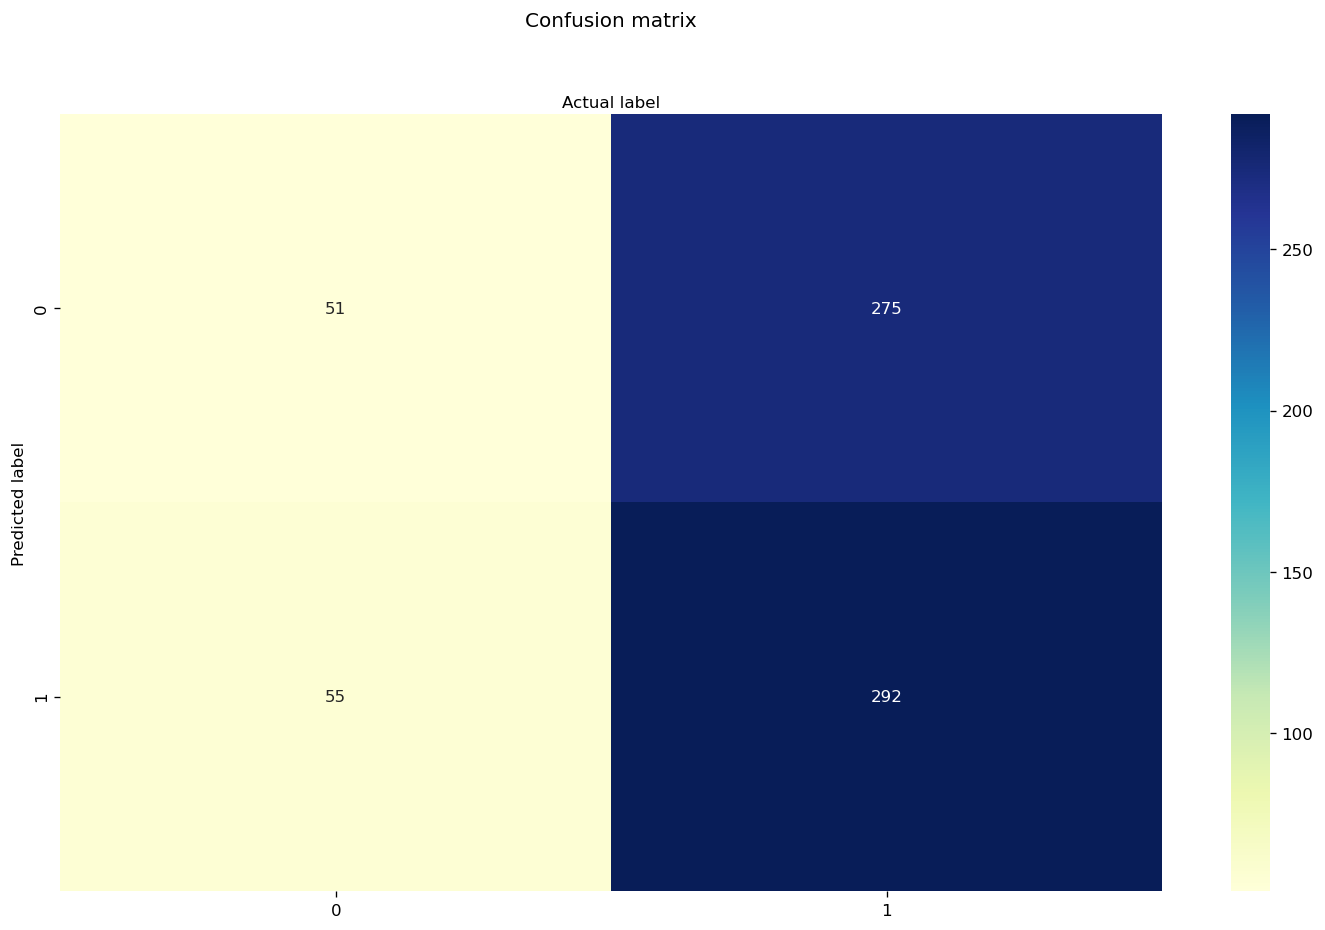

F1 Score : 0.639


In [123]:
y_test_l = y_test > 0
pred_l = pd.DataFrame(pred) > 0
pred_l.index = [i for i in range(1, len(pred_l)+1)]

pos = 0
for i in range(len(pred)):
    if (pred[i] > 0 and y_test[i+1] > 0) or (pred[i] <= 0 and y_test[i+1] <= 0):
        pos +=1
print('The classification accuracy for test set:', pos / len(pred))
build(y_test > 0, pred_l, 0)